In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [4]:
df.isnull().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [6]:
df.median_house_value = np.log1p(df.median_house_value)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN


In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [8]:
from sklearn.feature_extraction import DictVectorizer

In [9]:
dv = DictVectorizer(sparse=True)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)


### Q1

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



### Q2

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
y_pred = rf.predict(X_val)


In [16]:
from sklearn.metrics import mean_squared_error

round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)

0.245

### Q3

In [27]:
from tqdm.auto import tqdm

In [59]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
df_scores.rmse = [round(rmse, 3) for rmse in df_scores.rmse]
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.237
3,40,0.235
4,50,0.235
5,60,0.235
6,70,0.234
7,80,0.235
8,90,0.234
9,100,0.234


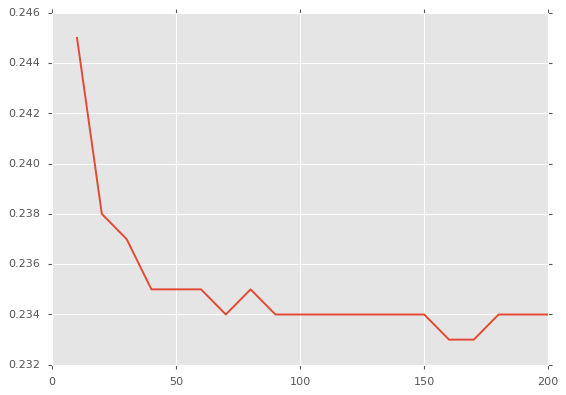

In [62]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

### Q4

In [64]:
scores = []

for d in tqdm([10, 15, 20, 25]):
  rf = RandomForestRegressor(n_estimators=0,
                              max_depth=d,
                              random_state=1, n_jobs=-1,
                              warm_start=True)

  for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

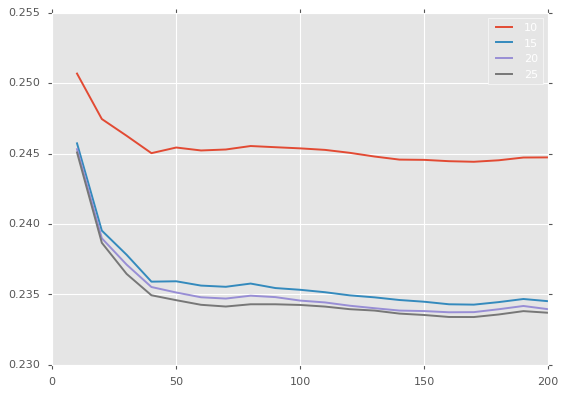

In [65]:
for d in [10, 15, 20, 25]:
  df_subset = df_scores[df_scores.max_depth == d]
  plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

### Q5

In [66]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [73]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806


### Q6

In [128]:
import xgboost as xgb

In [129]:
features = dv.get_feature_names_out().tolist()
features = [f.replace("<", "less_") for f in features ]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [130]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [131]:
def parse_xgb_output(output):
  results = []

  for line in output.stdout.strip().split('\n'):
    it_line, train_line, val_line = line.split('\t')

    it = int(it_line.strip('[]'))
    train = float(train_line.split(':')[1])
    val = float(val_line.split(':')[1])

    results.append((it, train, val))
  
  columns = ['num_iter', 'train_auc', 'val_auc']
  df_results = pd.DataFrame(results, columns=columns)
  return df_results

In [132]:
scores = {}

In [133]:
%%capture output

xgb_params = {
  'eta': 0.3, 
  'max_depth': 6,
  'min_child_weight': 1,

  'objective': 'reg:squarederror',
  'nthread': 8,

  'seed': 1,
  'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [134]:
scores['eta=0.3'] = parse_xgb_output(output)

#### eta=0.1

In [135]:
%%capture output

xgb_params = {
  'eta': 0.1, 
  'max_depth': 6,
  'min_child_weight': 1,

  'objective': 'reg:squarederror',
  'nthread': 8,

  'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [136]:
scores['eta=0.1'] = parse_xgb_output(output)

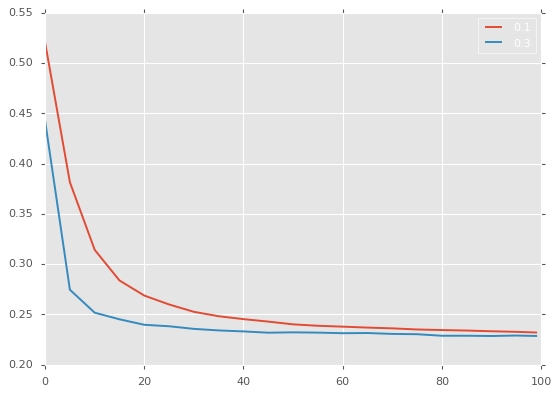

In [137]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.legend()